In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

np.random.seed(42)
tf.random.set_seed(42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'C:/Users/Badis/Desktop/COVID/data/train'
TESTING_DIR = 'C:/Users/Badis/Desktop/COVID/data/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 90 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


 {'Normal_cases': 40, 'Viral_Pneumonia_cases': 40, 'Covid_cases': 40}


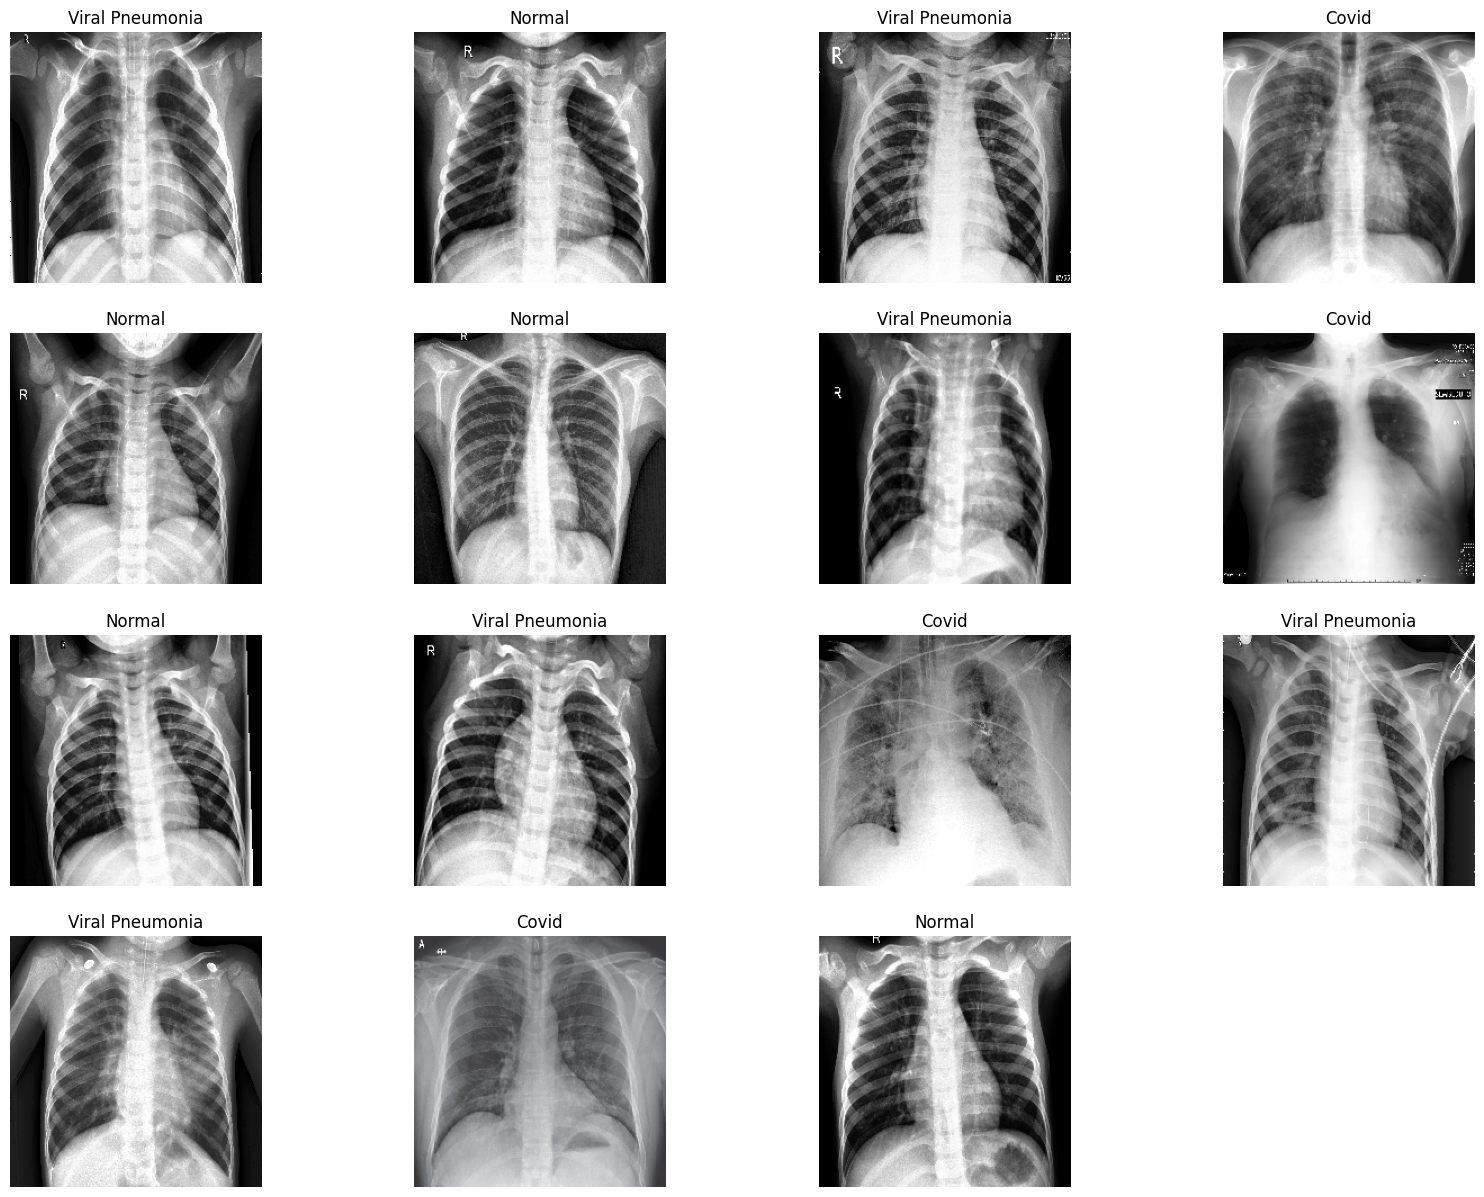

In [7]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [8]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                      

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50


2/2 [==============================] - ETA: 0s - loss: 1.2361 - acc: 0.3778
Epoch 1: acc improved from -inf to 0.37778, saving model to model\vgg16_best.h5
2/2 [==============================] - 12s 5s/step - loss: 1.2361 - acc: 0.3778 - val_loss: 1.0907 - val_acc: 0.3333
Epoch 2/50


C:\Users\Badis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - ETA: 0s - loss: 1.3048 - acc: 0.2556
Epoch 2: acc did not improve from 0.37778
2/2 [==============================] - 9s 4s/step - loss: 1.3048 - acc: 0.2556 - val_loss: 1.1051 - val_acc: 0.3333
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 1.1964 - acc: 0.3444
Epoch 3: acc did not improve from 0.37778
2/2 [==============================] - 9s 4s/step - loss: 1.1964 - acc: 0.3444 - val_loss: 1.0644 - val_acc: 0.4333
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 1.1781 - acc: 0.3556
Epoch 4: acc did not improve from 0.37778
2/2 [==============================] - 10s 4s/step - loss: 1.1781 - acc: 0.3556 - val_loss: 1.0332 - val_acc: 0.6000
Epoch 5/50
2/2 [==============================] - ETA: 0s - loss: 1.0995 - acc: 0.4556
Epoch 5: acc improved from 0.37778 to 0.45556, saving model to model\vgg16_best.h5
2/2 [==============================] - 9s 4s/step - loss: 1.0995 - acc: 0.4556 - val_loss: 1.0197 - val_a

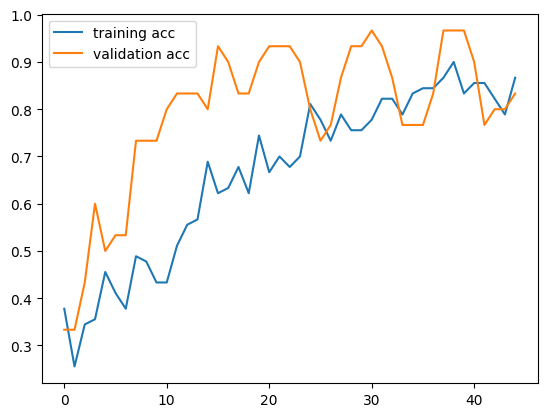

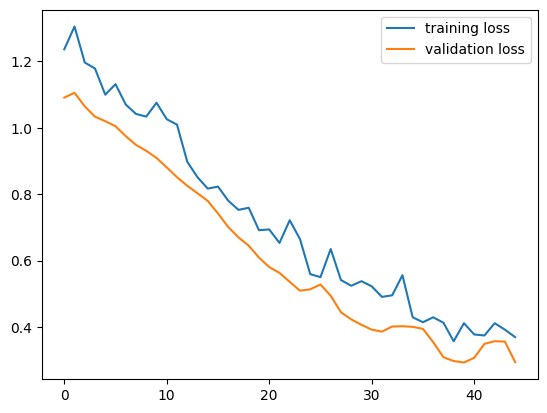

In [10]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [11]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.2933 - acc: 0.9667


,Train,Val
Loss,0.315783,0.293276
Acc,0.900000,0.966667


1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.90      0.95        10
         2.0       1.00      1.00      1.00        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



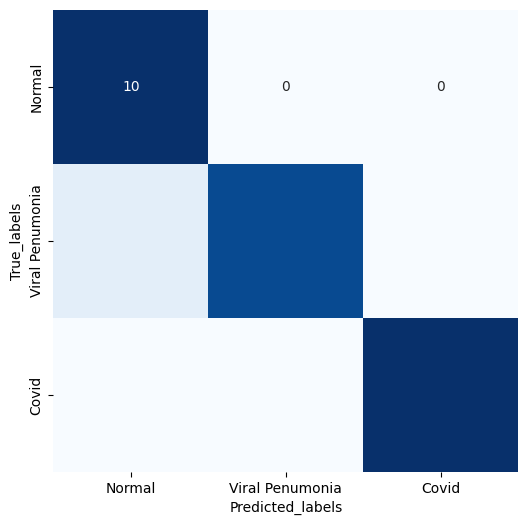

In [12]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

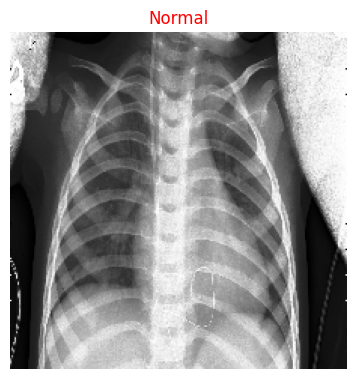

In [13]:
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

Found 90 images belonging to 3 classes.


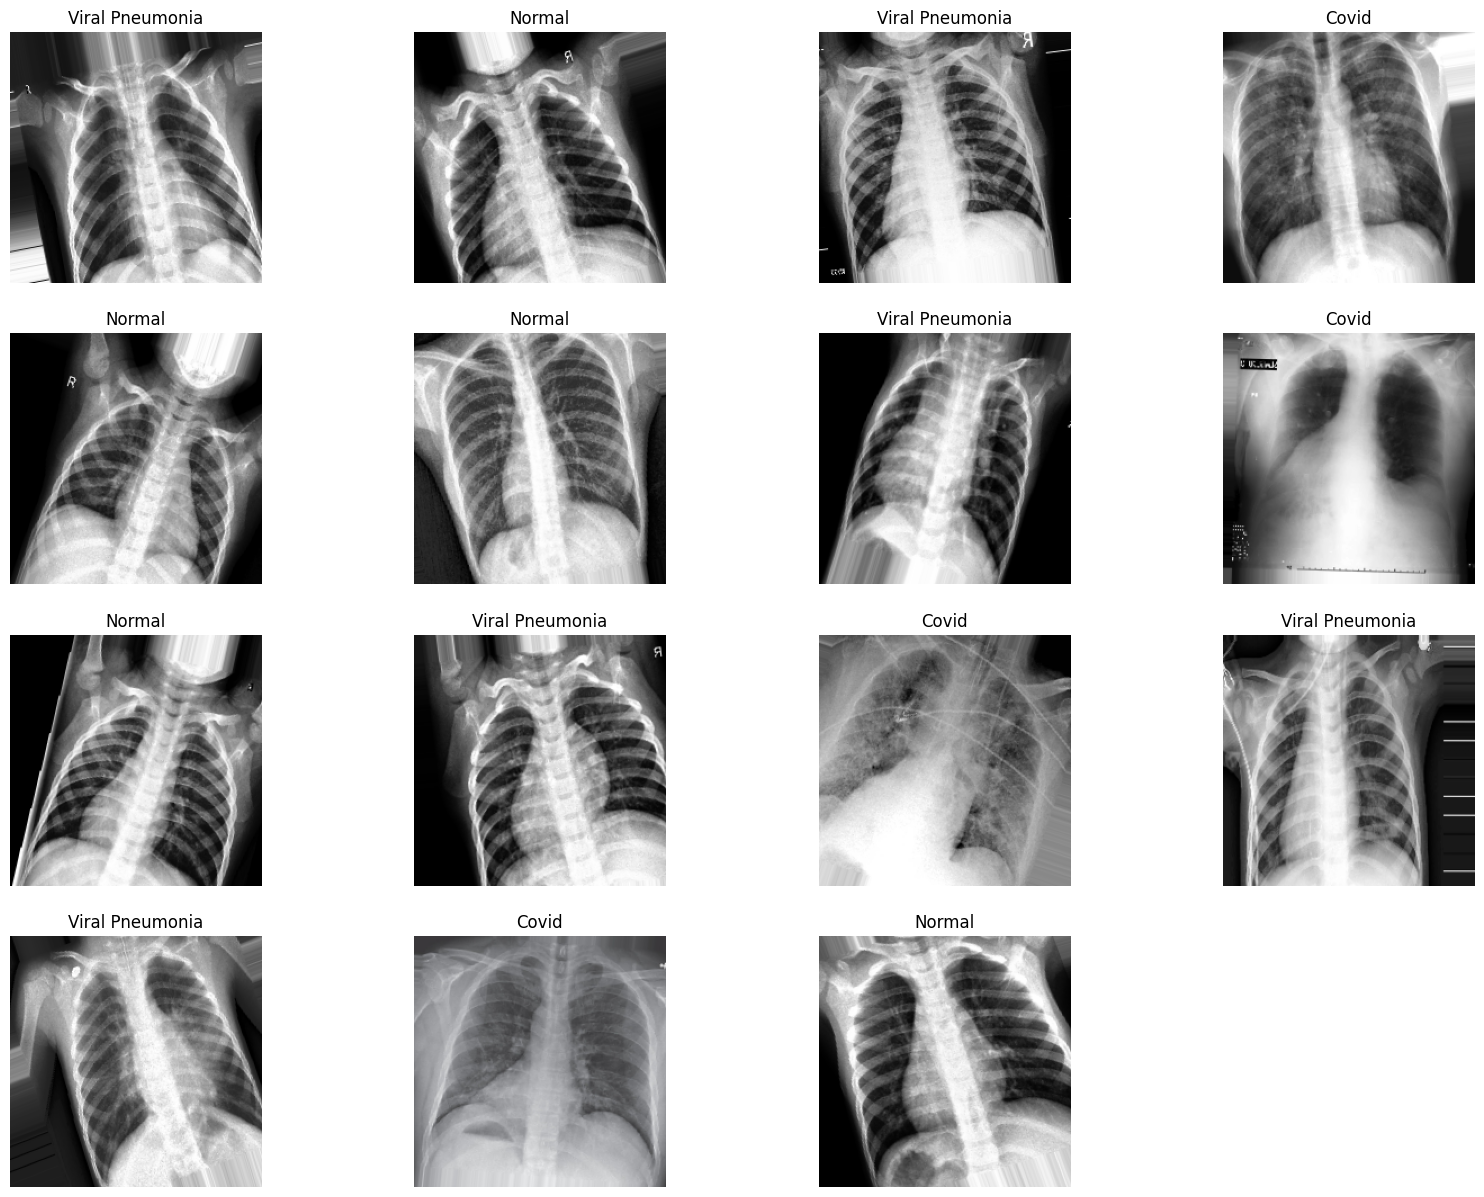

In [14]:
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,15)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=60, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/60
2/2 [==============================] - ETA: 0s - loss: 0.4996 - acc: 0.7444
Epoch 1: acc improved from -inf to 0.74444, saving model to model\vgg16_best.h5
2/2 [==============================] - 10s 4s/step - loss: 0.4996 - acc: 0.7444 - val_loss: 0.2808 - val_acc: 0.9667
Epoch 2/60


C:\Users\Badis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - ETA: 0s - loss: 0.4769 - acc: 0.8000
Epoch 2: acc improved from 0.74444 to 0.80000, saving model to model\vgg16_best.h5
2/2 [==============================] - 10s 4s/step - loss: 0.4769 - acc: 0.8000 - val_loss: 0.2765 - val_acc: 0.9667
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 0.3447 - acc: 0.9111
Epoch 3: acc improved from 0.80000 to 0.91111, saving model to model\vgg16_best.h5
2/2 [==============================] - 10s 4s/step - loss: 0.3447 - acc: 0.9111 - val_loss: 0.2801 - val_acc: 0.9667
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 0.4149 - acc: 0.8333
Epoch 4: acc did not improve from 0.91111
2/2 [==============================] - 10s 4s/step - loss: 0.4149 - acc: 0.8333 - val_loss: 0.2867 - val_acc: 0.9667
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 0.3752 - acc: 0.8778
Epoch 5: acc did not improve from 0.91111
2/2 [==============================] - 10s 4s/step - loss: 0.3

In [16]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.1406 - acc: 0.9667


,Train,Val
Loss,0.187872,0.140561
Acc,0.933333,0.966667


3/3 [==============================] - 5s 2s/step
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        30
         1.0       1.00      0.80      0.89        30
         2.0       0.97      1.00      0.98        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



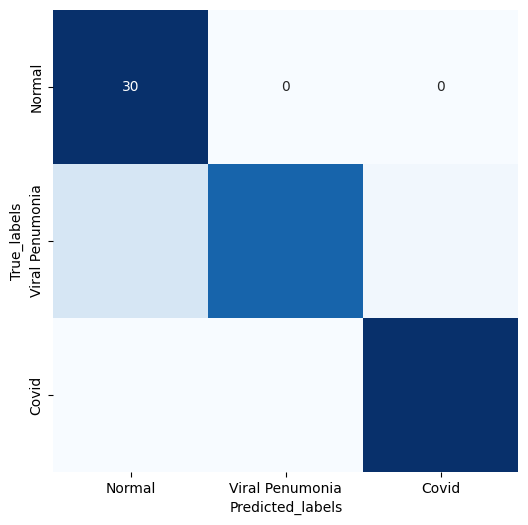

In [17]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.90      0.95        10
         2.0       1.00      1.00      1.00        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

thank you badis


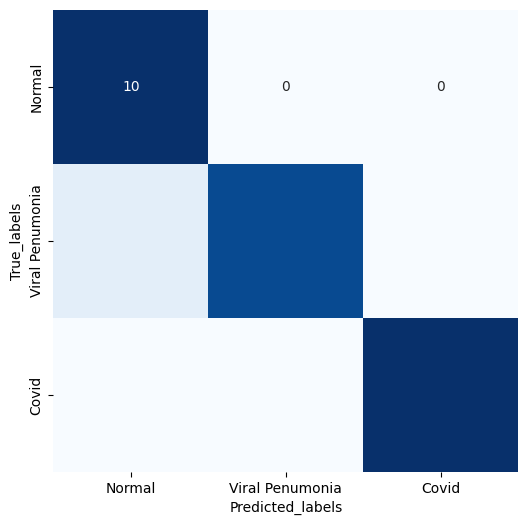

In [19]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))
print('thank you badis')